# Raw Jet Kinematics

In [1]:
import awkward as ak
import numpy as np
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from dask.distributed import Client
import matplotlib.pyplot as plt
from distributed.diagnostics.plugin import UploadDirectory
from collections import defaultdict
import correctionlib
from coffea.analysis_tools import PackedSelection
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Loading the Files

Let's start by opening the ROOT file to be analyzed; we use NanoEventsFactory to construct a TTree with NanoAOD schema out of them. We can view how the NanoAOD files are contructed here **[[1]](https://gitlab.cern.ch/cms-nanoAOD/nanoaod-doc/-/wikis/home)**, with special focus on the NanoAODv9  set from Run2. For example, our dataset wil be located in `samples/flatPU_JMENano_20XX.txt`, and the year range will be 2016, 2017, and 2018 (we are exluding the 2016APV dataset for the moment). Next, we see that `samples/flatPU_JMENano_20XX.txt` contains many ROOT files with the following format for their respective years:

- **2016 Era** -   `/store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_106X_mcRun2_asymptotic_preVFP_v11-v1/120000/0AC69980-C070-954D-A349-3F134CC8E5B8.root`
- **2017 Era** -   `/store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_20UL17JMENano_106X_mc2017_realistic_v9-v1/60000/044B12F6-C47A-A143-9A1D-6FC0A863E6AB.root`
- **2018 Era** -   `/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/2550000/00C4553F-498A-6C43-8144-3CE0FE0CEC15.root`

To access the files, we add the `root://xcache/` prefix when working on Coffea Casa. Sticking to the 2016 dataset for demonstration purposes, our first task once the TTree object has been created is to access its fields, which are much like keys from python dictionaries. As we can see from `/store/mc`, this is a Monte Carlo dataset and so its contents in their entirety can be found here **[[2]](https://cms-nanoaod-integration.web.cern.ch/autoDoc/NanoAODv9/2016ULpreVFP/doc_TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8_RunIISummer20UL16NanoAODAPVv9-106X_mcRun2_asymptotic_preVFP_v11-v1.html)**. For now, lets view all of its fields/keys:

In [2]:
my_file = 'root://xcache//store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_106X_mcRun2_asymptotic_preVFP_v11-v1/120000/0AC69980-C070-954D-A349-3F134CC8E5B8.root'
#my_file = 'root://xcache//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_20UL17JMENano_106X_mc2017_realistic_v9-v1/60000/044B12F6-C47A-A143-9A1D-6FC0A863E6AB.root'
#my_file = 'root://xcache//store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/2550000/00C4553F-498A-6C43-8144-3CE0FE0CEC15.root'
my_events = NanoEventsFactory.from_root(my_file, schemaclass=NanoAODSchema).events()
my_events.fields

['CorrT1METJet',
 'PuppiMET',
 'SV',
 'HLTriggerFirstPath',
 'SubJet',
 'fixedGridRhoFastjetCentralCalo',
 'PSWeight',
 'SoftActivityJetHT2',
 'CaloMET',
 'RawMET',
 'MET',
 'ChsMET',
 'FsrPhoton',
 'SoftActivityJetNjets5',
 'Flag',
 'event',
 'IsoTrack',
 'Tau',
 'run',
 'Muon',
 'TrigObj',
 'GenVisTau',
 'RawPuppiMET',
 'L1Reco',
 'SoftActivityJetNjets10',
 'btagWeight',
 'L1',
 'TkMET',
 'SoftActivityJetNjets2',
 'FatJet',
 'fixedGridRhoFastjetCentralNeutral',
 'L1PreFiringWeight',
 'GenIsolatedPhoton',
 'OtherPV',
 'DeepMETResponseTune',
 'GenJetAK8',
 'SoftActivityJet',
 'genTtbarId',
 'HTXS',
 'genWeight',
 'SoftActivityJetHT10',
 'GenDressedLepton',
 'PV',
 'L1simulation',
 'GenVtx',
 'Electron',
 'DeepMETResolutionTune',
 'SoftActivityJetHT',
 'SubGenJetAK8',
 'HLTriggerFinalPath',
 'SoftActivityJetHT5',
 'fixedGridRhoFastjetAll',
 'Generator',
 'fixedGridRhoFastjetCentral',
 'Pileup',
 'GenPart',
 'Jet',
 'luminosityBlock',
 'LowPtElectron',
 'HLT',
 'boostedTau',
 'GenJet',
 

Since we are interested in jet kinematics, let us focus on the `GenJet`, `Jet`, `GenVTX`, `PV`, `Pileup`, and `fixedGridRhoFastjetAll` fields first. Their definitions are:

- **GenJet** -   slimmedGenJets, i.e. ak4 MC Jets made with visible genparticles; pure MC simulated jets generated by clustering energies of MC particles.
- **Jet** -   slimmedJets, i.e. ak4 PF Jets CHS with JECs applied, after basic selection ($p_T > 15$).
- **GenVTX** -   gen vertex.
- **PV** -   main primary vertex.
- **Pileup** -     the true mean number of the poisson distribution for this event from which the number of interactions each bunch crossing has been sampled.
- **fixedGridRhoFastjetAll** -     rho from all PF Candidates, used e.g. for JECs.

Here `GenJet` and `Jet` will have jet kinematics as sub-fields, which we can immediately put into histograms to analyze their distributions; we will come back to the other four fields shortly. We can also use `events.GenJetAK8` and `events.FatJet` to obtain MC/PF jets clustered with the AK8 rather than AK4 algorithm, though we will focus on AK4 jets. As always, we can use `my_events.Jet?` or `help(my_events.Jet)` for help with documentation with any field.
 
First lets define our jet objects, which will consist of a MC-generated jet, a PF reconstructed jet, and a reconstructed jet that is within $R = \sqrt{\eta^{2} + \phi^{2}} < 0.2$ in the eta-phi plane of the MC jet. The `nearest` method forms part of the `LorentzVector` class in coffea, and its documentation can be found here **[[3]](https://github.com/CoffeaTeam/coffea/blob/ab27195200c46c9b9875e484114ff171b9ea285f/src/coffea/nanoevents/methods/vector.py)**. When applying this method to every jet in every event, coffea seems to shut down, and so we will select only the first 3 leading jets in each event, which will have the jets with the leading transverse momenta. Physically, we want to keep leading jets since they have the highest transverse momenta and can thus be assocated with primary interactions. This is the only cut that we will apply for now, but we will add more as our analysis becomes more involved.

In [3]:
gen_jets = my_events.GenJet
reco_jets = my_events.Jet
reco_jets_nearest = gen_jets.nearest(reco_jets[:, 0:3], threshold=0.2)

print(f'GenJet Sub-fields: {gen_jets.fields}\n\nJet Sub-fields: {reco_jets.fields}\n')

GenJet Sub-fields: ['eta', 'mass', 'phi', 'pt', 'partonFlavour', 'hadronFlavour']

Jet Sub-fields: ['area', 'btagCSVV2', 'btagDeepB', 'btagDeepCvB', 'btagDeepCvL', 'btagDeepFlavB', 'btagDeepFlavCvB', 'btagDeepFlavCvL', 'btagDeepFlavQG', 'chEmEF', 'chFPV0EF', 'chHEF', 'eta', 'hfsigmaEtaEta', 'hfsigmaPhiPhi', 'mass', 'muEF', 'muonSubtrFactor', 'neEmEF', 'neHEF', 'phi', 'pt', 'puIdDisc', 'qgl', 'rawFactor', 'bRegCorr', 'bRegRes', 'cRegCorr', 'cRegRes', 'electronIdx1', 'electronIdx2', 'hfadjacentEtaStripsSize', 'hfcentralEtaStripSize', 'jetId', 'muonIdx1', 'muonIdx2', 'nElectrons', 'nMuons', 'puId', 'nConstituents', 'genJetIdx', 'hadronFlavour', 'partonFlavour', 'cleanmask', 'electronIdx1G', 'electronIdx2G', 'genJetIdxG', 'muonIdx1G', 'muonIdx2G', 'muonIdxG', 'electronIdxG']



Fields of particular interest will be `eta`, `phi`,  and `pt` for both `GenJet` ***and*** `Jet`, as well as `area` and `jetId` for `Jet` ***only***. The definitions of the latter two are:

- **Jet.area** -     jet catchment area, for JECs.
- **Jet.jetId** -     jet ID flags bit1 is loose (always false in 2017 since it does not exist), bit2 is tight, bit3 is tightLepVeto

We will use these attibutes when performing JER corrections and applying event selection masks on our jets. The next step will be to obtain histograms in order to visualize the contents of our file.

### Plotting Raw Jet Kinematics

We begin by defining the eta, phi, and pt kinematics for each of our three jets, and then proceed to print their respective extrema, which will help us choose an appropriate binning.

In [4]:
print("Gen jets extrema:")
print(f"Eta: {np.min(ak.ravel(gen_jets.eta))}, {np.max(ak.ravel(gen_jets.eta))}")
print(f"Phi {np.min(ak.ravel(gen_jets.phi))}, {np.max(ak.ravel(gen_jets.phi))}")
print(f"Pt: {np.min(ak.ravel(gen_jets.pt))}, {np.max(ak.ravel(gen_jets.pt))}\n")

print("Reco jets extrema:")
print(f"Eta: {np.min(ak.ravel(reco_jets.eta))}, {np.max(ak.ravel(reco_jets.eta))}")
print(f"Phi: {np.min(ak.ravel(reco_jets.phi))}, {np.max(ak.ravel(reco_jets.phi))}")
print(f"Pt: {np.min(ak.ravel(reco_jets.pt))}, {np.max(ak.ravel(reco_jets.pt))}\n")

print("Reco jets nearest extrema:")
print(f"Eta: {np.min(ak.ravel(reco_jets_nearest.eta))}, {np.max(ak.ravel(reco_jets_nearest.eta))}")
print(f"Phi: {np.min(ak.ravel(reco_jets_nearest.phi))}, {np.max(ak.ravel(reco_jets_nearest.phi))}")
print(f"Pt: {np.min(ak.ravel(reco_jets_nearest.pt))}, {np.max(ak.ravel(reco_jets_nearest.pt))}\n")

Gen jets extrema:
Eta: -6.8017578125, 6.8193359375
Phi -3.1416015625, 3.1416015625
Pt: 10.000000953674316, 6453.2783203125

Reco jets extrema:
Eta: -8.08984375, 6.12890625
Phi: -3.1416015625, 3.1416015625
Pt: 15.0, 13408.0

Reco jets nearest extrema:
Eta: -5.09375, 5.08984375
Phi: -3.1416015625, 3.1416015625
Pt: 15.0, 13408.0



From these values we can see that the ranges of $\eta$ and the azimuthal angle $\phi$ are fairly symmetric, while the $p_T > 15$ as expected. Although we are interested in jets with high $p_T$ located in the central region of the CMS detector (i.e. in regions where as $\eta < 2.4$ for example), we explicitly give the entire range in the histograms below.

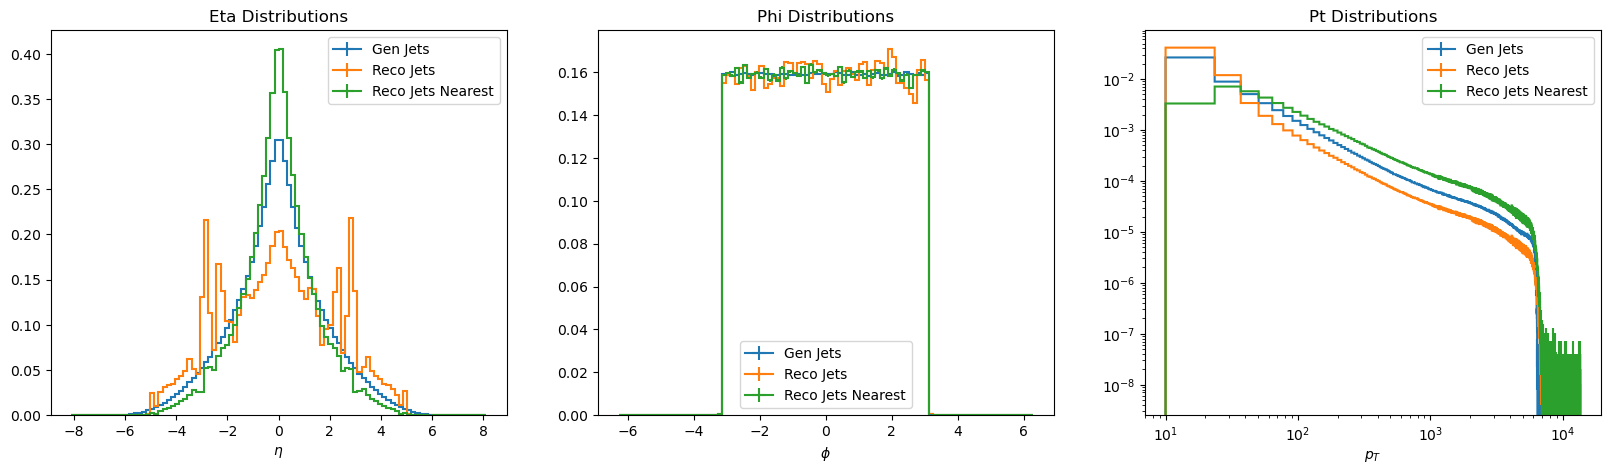

In [5]:
eta_axis = hist.axis.Regular(100, -8.1, 8.1, name="eta", label="$\eta$") 
phi_axis = hist.axis.Regular(100, -2*np.pi, 2*np.pi, name="phi", label="$\phi$")
pt_axis = hist.axis.Regular(1000, 10, 13500, name="pt", label="$p_T$")

gen_jets_hist = hist.Hist(eta_axis, phi_axis, pt_axis)
reco_jets_hist = hist.Hist(eta_axis, phi_axis, pt_axis)
reco_jets_nearest_hist = hist.Hist(eta_axis, phi_axis, pt_axis)

gen_jets_hist.fill(eta=ak.ravel(gen_jets.eta), phi=ak.ravel(gen_jets.phi), pt=ak.ravel(gen_jets.pt))
reco_jets_hist.fill(eta=ak.ravel(reco_jets.eta), phi=ak.ravel(reco_jets.phi), pt=ak.ravel(reco_jets.pt))
reco_jets_nearest_hist.fill(eta=ak.ravel(reco_jets_nearest.eta), phi=ak.ravel(reco_jets_nearest.phi), pt=ak.ravel(reco_jets_nearest.pt))

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

gen_jets_hist.project('eta').plot(ax=axs[0], label="Gen Jets", density=True)
gen_jets_hist.project('phi').plot(ax=axs[1], label="Gen Jets", density=True)
gen_jets_hist.project('pt').plot(ax=axs[2], label="Gen Jets", density=True)

reco_jets_hist.project('eta').plot(ax=axs[0], label="Reco Jets", density=True)
reco_jets_hist.project('phi').plot(ax=axs[1], label="Reco Jets", density=True)
reco_jets_hist.project('pt').plot(ax=axs[2], label="Reco Jets", density=True)

reco_jets_nearest_hist.project('eta').plot(ax=axs[0], label="Reco Jets Nearest", density=True)
reco_jets_nearest_hist.project('phi').plot(ax=axs[1], label="Reco Jets Nearest", density=True)
reco_jets_nearest_hist.project('pt').plot(ax=axs[2], label="Reco Jets Nearest", density=True)

axs[0].set_title("Eta Distributions")
axs[0].legend()
axs[1].set_title("Phi Distributions")
axs[1].legend()
axs[2].set_title("Pt Distributions")
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].legend()
plt.show()

The three histograms above correspond to the jet distributions projected over pseudorapidity, azimuthal angle, and transverse momentum bins. Each histogram also contains the distributions of MC Generator-level Jets, PF Jets, and the three leading PF Jets with the constraint $R < 0.2$ as described before. The distributions follow the shapes that we expect:

- A symmetric peak in the central $\eta = 0 $ region of the detector, where $p_T$ is the highest. The jet distributions drop with increasing $\eta$ (i.e. towards the endcaps) since here the jets are collinear with the incoming beams, indicating low $p_T$.
- A uniform distributions with respect to the azimuthal angle $\phi$.
- A jet distribution that drops with increasing $p_T$. The number of events per $p_T$ bin remains relatively high for over four orders of magnitude, thus we use a double logarithmic plot.

### Plotting Other Jet Observables

In order to be able to perform calibrations to the Jet Energy Resolution, we need to be able to obtain other jet quantities such as the energy per unit $\eta \times \phi$ area ($\rho$), the number of reconstructed primary vertices ($N_{PV})$, and the number of pileup interactions ($N_{PU} = \mu$) as described in these papers **[[4]](https://arxiv.org/abs/1607.03663)**, **[[5]](https://arxiv.org/abs/0707.1378v2)**. As before, we start by examining some extrema:

In [6]:
reco_rho = my_events.fixedGridRhoFastjetAll
n_reco_vtx = my_events.PV.npvs 
n_pileup = my_events.Pileup.nPU 
pu_nTrueInt = my_events.Pileup.nTrueInt

print(f"Max rho value: {np.max(reco_rho)}")
print(f"Max number of reconstructed PV: {np.max(n_reco_vtx)}")
print(f"Max number of PU interactions added: {np.max(n_pileup)}")
print(f"Max nTrueInt value: {np.max(reco_rho)}\n")

Max rho value: 94.52728271484375
Max number of reconstructed PV: 185
Max number of PU interactions added: 111
Max nTrueInt value: 94.52728271484375



The pileup parameter $\rho$ is a measure of all the jet energies divided over their corresponding areas in an event, and is therefore an energy density. It forms a background against our measurements, thus we can correct them using $p_{T, i}^{CORR} = p_{T, i}^{RECO} - (\rho \cdot \rm{area_{jet, i}}) \hspace{1mm}$ where the energy density of the event is $\rho = \rm{median}\hspace{1mm}(p_{T,i}^{RECO} / \rm{area_{jet, i}})$. We take the median of the jet energies rather than the average to exclude jets with hight pT, and note that the area of a jet clustered an AK-R algorithm is approximately $\pi R^{2}$.

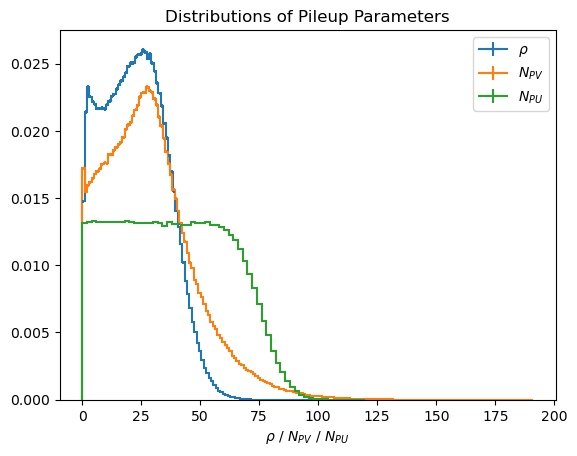

In [7]:
rho_axis = hist.axis.Regular(100, 0, 101, name="rho")
npvs_axis = hist.axis.Regular(190, 0, 191, name="npvs")
npu_axis = hist.axis.Regular(60, 0, 120, name="npu")

corrections_histogram = hist.Hist(rho_axis, npvs_axis, npu_axis)

corrections_histogram.fill(rho=ak.ravel(reco_rho), npvs=ak.ravel(n_reco_vtx), npu=ak.ravel(n_pileup))

corrections_histogram.project('rho').plot(density=True, label=r"$\rho$")
corrections_histogram.project('npvs').plot(density=True, label="$N_{PV}$")
corrections_histogram.project('npu').plot(density=True, label="$N_{PU}$")

plt.title("Distributions of Pileup Parameters")
plt.xlabel(r"$\rho$ / $N_{PV}$ / $N_{PU}$")
plt.legend()
plt.show()

Ideally number of reconstructed PV equals the number of PU events added, however the vertex finding efficency is not $100\%$ and so we have $N_{PV} \sim 0.70 N_{PU}$ instead. Next we attempt a naive calculation of $\rho$ using its definition; the actual computation of $\rho$ involves the additon of ghost particles with infinitesimal momenta to our jets, however for the purpose of comparison we employ the following simple algorithm:

Time to make reco_jets_rho: 20.882457494735718 seconds



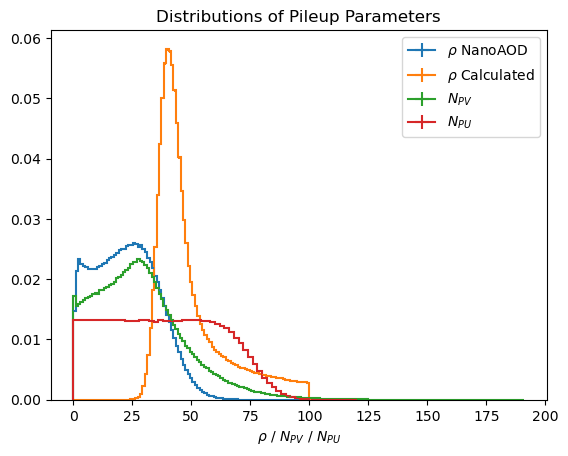

In [8]:
import time

reco_jets_pt = reco_jets.pt
reco_jets_area = reco_jets.area
reco_jets_frac = ak.Array(reco_jets_pt / reco_jets_area)
reco_jets_frac_list = reco_jets_frac.to_list()

reco_jets_rho = []
start_time = time.time()

for i in reco_jets_frac_list:
    if i:
        rho = np.median(i)
        reco_jets_rho.append(rho)
    else:
        continue

reco_jets_rho = np.array(reco_jets_rho)
reco_jets_rho = reco_jets_rho[reco_jets_rho < 100]

end_time = time.time()
delta_t = end_time - start_time

print(f"Time to make reco_jets_rho: {delta_t} seconds\n")
         
calculated_rho_histogram = hist.Hist(rho_axis)

calculated_rho_histogram.fill(rho=ak.ravel(reco_jets_rho))

corrections_histogram.project('rho').plot(density=True, label=r"$\rho$ NanoAOD")
calculated_rho_histogram.project('rho').plot(density=True, label=r"$\rho$ Calculated")
corrections_histogram.project('npvs').plot(density=True, label="$N_{PV}$")
corrections_histogram.project('npu').plot(density=True, label="$N_{PU}$")

plt.title("Distributions of Pileup Parameters")
plt.xlabel(r"$\rho$ / $N_{PV}$ / $N_{PU}$")
plt.legend()
plt.show()

Although the amplitudes of the $\rho$ distributions do not match, their peaks are centered around comparable values. In any case, we won't actually be using this procedure in our analysis at all. The last task we want to do is to create a histogram of the jet IDs in our events, which is a criteria used for retaining real jets and rejecting fake jets from noise; they will be useful when applying masks to perform cuts on our jets. Further documentation on jet ID can be found here **[[6]](https://cds.cern.ch/record/1279362/files/JME-10-003-pas.pdfhttps://cds.cern.ch/record/1279362/files/JME-10-003-pas.pdf)**, **[[7]](https://twiki.cern.ch/twiki/bin/viewauth/CMS/JetIDhttps://twiki.cern.ch/twiki/bin/viewauth/CMS/JetID)**. For example, for 2017 and 2018 samples jetId==$2$ means pass Tight ID but fail TightLeptVeto ID, while jetId==$6$ mean pass both. The criteria the jets must pass are given in the table below for AK4CHS jets in different $\eta$ regions: 

|          | $|\eta| \le 2.7$ For AK4CHS and PUPPI Jets _________________________________ |          | $2.7 < |\eta| \le 3.0$ For AK4CHS Jets _____________________________ |     | $|\eta| > 3.0$ For AK4CHS Jets ________________________ |          | 
|:----------------------------:|:------------------:|:------------------:|:------------------:|:------------------:|:------------------:|:------------------:|           
| $\bf{PF Jet ID}$             | $\bf{Tight}$       | $\bf{TightLepVeto}$| $\bf{Tight}$       | $\bf{TightLepVeto}$| $\bf{Tight}$       | $\bf{TightLepVeto}$|
| Neutral Hadron Fraction      | < 0.90             | < 0.90             | -                  | -                  | > 0.02             | -                  |
| Neutral EM Fraction          | < 0.90             | < 0.90             | > 0.02 and < 0.99  | -                  | < 0.90             | -                  |  
| Number of Constitutents      | > 1                | > 1                | -                  | -                  | -                  | -                  |
| Muon Fraction                | -                  | < 0.80             | -                  | -                  | -                  | -                  |
| Number of Neutral Particles  | -                  | -                  | > 2                | -                  | > 10               | -                  |        

Ration of jetId=0 to jetId=6 jets: 0.03139131494282251



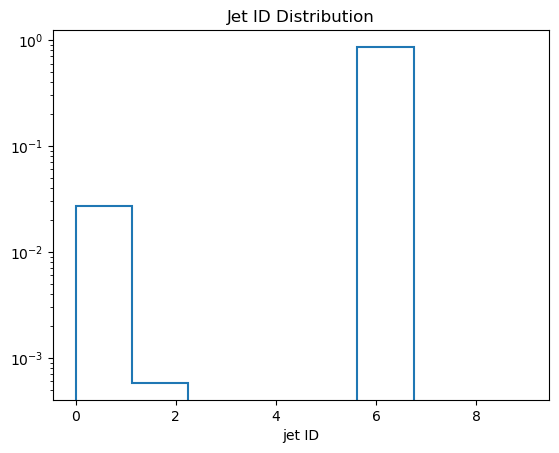

In [9]:
jetIds = reco_jets.jetId

jetIds_ratio = len(ak.ravel(jetIds[jetIds==0])) / len(ak.ravel(jetIds[jetIds==6]))
print(f"Ration of jetId=0 to jetId=6 jets: {jetIds_ratio}\n")

jetIdaxis = hist.axis.Regular(8, 0, 9, name="id", label="jet ID")

jetId_hist = hist.Hist(jetIdaxis)

jetId_hist.fill(id=ak.ravel(jetIds))

jetId_hist.project('id').plot(density=True)

plt.title("Jet ID Distribution")
plt.yscale('log')
plt.show()